## DreliaCalc Report

In [1]:
# Date of Calculation
import arrow
dateformat='DD.MM.YYYY - HH:mm'
print(arrow.now('Europe/Vienna').format(dateformat))

31.03.2021 - 20:39


In [2]:
# Import packages
%cd ../dReliaCalc
import dmyplant2
import pandas as pd
import numpy as np
from pprint import pprint as pp

/Users/dieterchvatal/Documents/Anaconda/dReliaCalc


In [3]:
# Read Input CSV files (Upload first ... )
dval = pd.read_csv("input2.csv",sep=';', encoding='utf-8')
dval['val start'] = pd.to_datetime(dval['val start'], format='%d.%m.%Y')
failures = pd.read_csv("failures.csv",sep=';', encoding='utf-8')
failures['date'] = pd.to_datetime(failures['date'], format='%d.%m.%Y')

In [4]:
# identify yourself & create instances
from dmyplant2 import cred
mp = dmyplant2.MyPlant(60)
vl = dmyplant2.Validation(mp,dval, cui_log=True)                   

00 1145166 M02 POLYNT - 2 (1145166- ..
01 1175579 M05 REGENSBURG             
02 1184199 M01 ROCHE PENZBERG KWKK    
03 1198719 M02 ECOGEN ENERGY SYSTEM ..
04 1243360 M03 BMW REGENSBURG M3      
05 1243362 M02 REGENSBURG             
06 1250575 M01 ABINSK                 
07 1250578 M01 PROSPERITY WEAVING M ..
08 1310773 M01 SOTERNIX RENOVE        
09 1319133 M4 BMW MÜNCHEN            
10 1319138 M2 BMW MÜNCHEN            
11 1319151 M1 BMW MÜNCHEN            
12 1319157 M3 BMW MÜNCHEN            
13 1319997 M2 BMW MÜNCHEN            
14 1320022 M1 BMW MÜNCHEN            
15 1320030 M3 BMW MÜNCHEN            
16 1320072 M4 BMW LANDSHUT 4.10      
17 1320090 M1 BMW LANDSHUT M1        
18 1320114 M3 BMW LANDSHUT 4.10      
19 1325927 M01 LES COURONNERIES       
20 1339812 M01 DALOMA                 
21 1345851 M03 GAZ DE LACQ            
22 1352268 M6 BMW DINGOLFING 2.4     
23 1352323 M7 BMW DINGOLFING 2.4     
24 1361965 M01 FRONERI - FERENTINO    
25 1364066 M01 TOM VILLE             

## Success Run Plot, beta=1.21 & 1.5 with failures 

In [5]:
# dashboard
d=vl.dashboard
#d.sort_values(by = "oph parts",ascending=False)

In [6]:
# Read Values defined in tdef from Myplant into a pd.dataframe
#tdef = {161: 'Count_OpHour', 102: 'Power_PowerAct', 1258: 'OperationalCondition', 19074: 'Various_Bits_CollAlarm'}
tdef = {1258: 'OperationalCondition', 19074: 'Various_Bits_CollAlarm'}
ntable = [[e] + [e.get_dataItem(v) for v in tdef.values()] for e in vl.engines]
dft = pd.DataFrame(ntable, columns=['Name'] + list(tdef.values()))

In [7]:
# Summary of current Operation condition
from tabulate import tabulate
print(f"{dft.OperationalCondition.count()} Validation Engines observed.")
print(f"{dft[dft.OperationalCondition == 'Running'].OperationalCondition.count()} Validation Engines UP and Running")
print(f"{dft[dft.OperationalCondition != 'Running'].OperationalCondition.count()} Validation Engines not Running: \n")
print(tabulate(dft[dft.OperationalCondition != 'Running'], headers=dft.columns),"\n")

35 Validation Engines observed.
27 Validation Engines UP and Running
8 Validation Engines not Running: 

    Name                          OperationalCondition      Various_Bits_CollAlarm
--  ----------------------------  ----------------------  ------------------------
 9  1319133 M4 BMW MÜNCHEN        Available                                      0
12  1319157 M3 BMW MÜNCHEN        Available                                      0
14  1320022 M1 BMW MÜNCHEN        Not Available                                  1
17  1320090 M1 BMW LANDSHUT M1    Available                                      0
18  1320114 M3 BMW LANDSHUT 4.10  Available                                      0
25  1364066 M01 TOM VILLE         Available                                      0
27  1386177 M09 ABINSK            Not Available                                  1
33  1393378 M01 KAMAL LIMITED     Available                                      0 



In [8]:
dtripped = dft[dft.OperationalCondition == 'Tripped']
for eng in dtripped.values:
    le = eng[0] 
    print(le)
    dtrips = le.batch_hist_alarms(p_severities=[800], p_offset=0, p_limit=5)
    dtrips['datetime'] = pd.to_datetime(dtrips['timestamp'] * 1000000.0).dt.strftime("%m-%d-%Y %H:%m")
    print(tabulate(dtrips[['datetime', 'message', 'name','severity']]))
    print()

In [9]:
#failures = pd.DataFrame([])
from tabulate import tabulate
print(tabulate(failures, headers=failures.columns))
#pd.options.display.max_columns = None
#failures

    date                   failures    serialNumber  comment
--  -------------------  ----------  --------------  --------------------------------------
 0  2020-12-28 00:00:00           1         1319151  München V008 M1 Z8 - cold scuff Reiber


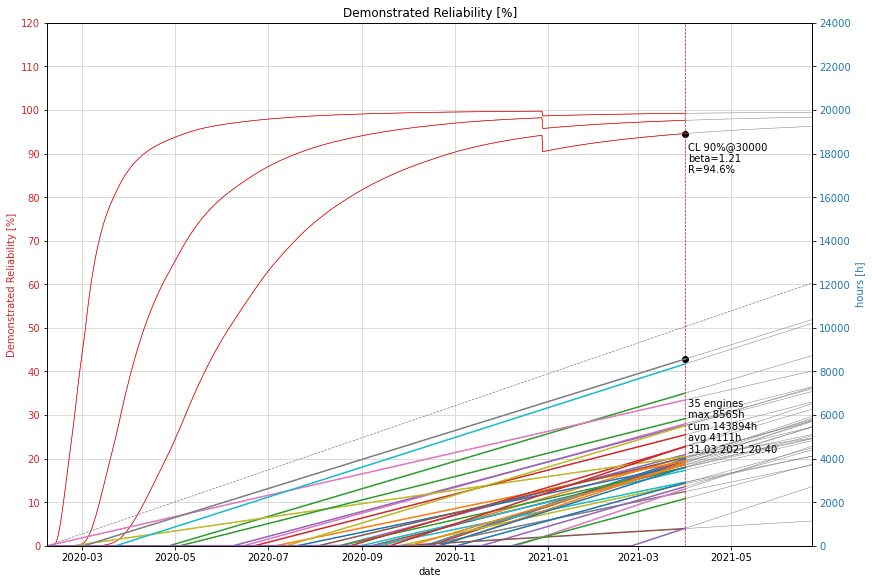

CPU times: user 2.17 s, sys: 150 ms, total: 2.32 s
Wall time: 2.31 s


In [10]:
%%time
dmyplant2.demonstrated_Reliabillity_Plot(vl, 
            beta=1.21, T=30000, s=1000, ft=failures, cl=[10,50,90], factor=1.2)

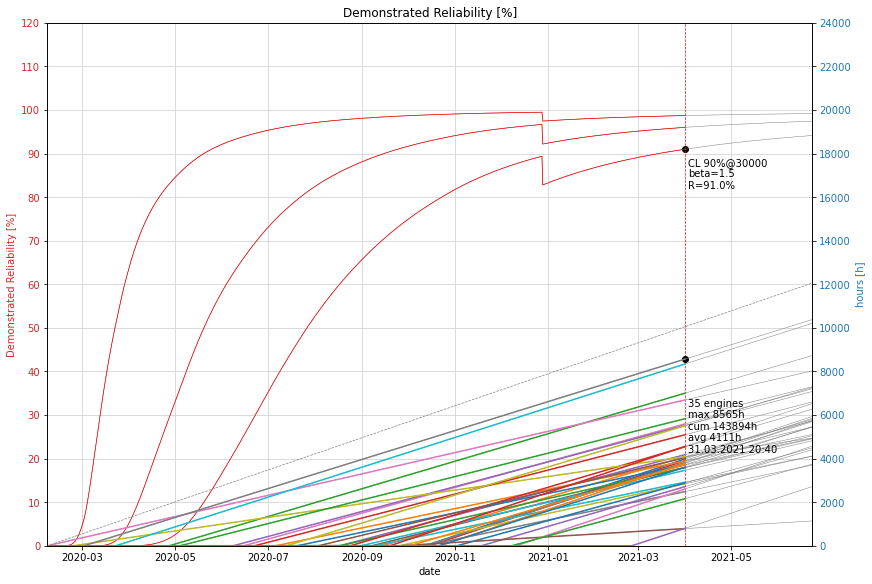

CPU times: user 2.23 s, sys: 106 ms, total: 2.34 s
Wall time: 2.35 s


In [11]:
%%time
dmyplant2.demonstrated_Reliabillity_Plot(vl, 
            beta=1.5, T=30000, s=1000, ft=failures, cl=[10,50,90], factor=1.2)

In [12]:
#failures = pd.DataFrame([])
#dmyplant2.demonstrated_Reliabillity_Plot(vl, 
#            beta=1.21, T=30000, s=1000, ft=failures, cl=[10,50,90], factor=1.2)

In [13]:
#dmyplant2.demonstrated_Reliabillity_Plot(vl, 
#            beta=1.5, T=30000, s=1000, ft=failures, cl=[10, 50, 90], factor=1.2)

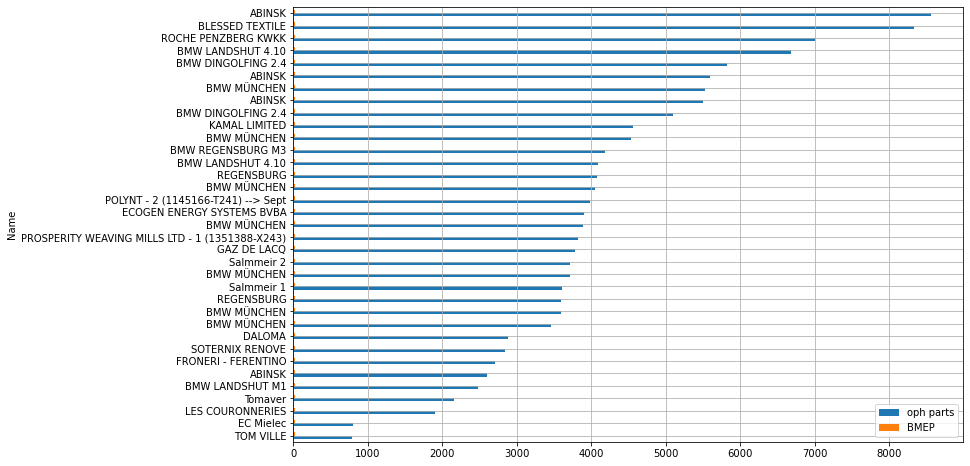

In [14]:
d[['Name','oph parts','BMEP']].set_index('Name').sort_values(by = "oph parts",ascending=True)[["oph parts","BMEP"]].plot.barh(figsize=(12,8),grid=True);

## Engines in oph ranges

In [15]:
import itertools as it
import matplotlib.pyplot as plt
#Calculate the number f engines in certain oph ranges
ranges = [2000,3000,4000,5000,6000,7000,8000,10000]
#Method 1: using cut and groupby
#r = d.groupby(pd.cut(d['oph parts'], ranges)).count()
#r['id']

#Method 2: simpler, direct using pd.value_counts
print(f"{d['oph parts'].count()} Engines in Validation fleet with total {d['oph parts'].sum()} Operation hours")
#d['oph parts'].value_counts(bins=ranges, sort=False).astype(int).plot.bar(ylim=(0,25))
erg = list(d['oph parts'].value_counts(bins=ranges, sort=False).astype(int))
#pd.DataFrame(list(zip(reversed(ranges[:-1]),it.accumulate(list(reversed(erg))))),columns=['oph','engines'])
pd.DataFrame(zip(reversed(ranges[:-1]),it.accumulate(reversed(erg))),columns=['oph','engines'])

35 Engines in Validation fleet with total 143894 Operation hours


,oph,engines
0,8000,2
1,7000,3
2,6000,4
3,5000,9
4,4000,15
5,3000,26
6,2000,32


## Statistics by Engine Type

In [16]:
d.groupby( "Engine Type")['oph parts'].describe().fillna(0).astype(int)

,count,mean,std,min,25%,50%,75%,max
Engine Type,,,,,,,,
612,1,2884,0,2884,2884,2884,2884,2884
616,9,3535,791,2159,2845,3785,4078,4559
620,6,3964,2437,789,3493,3649,3848,8342
624,19,4495,1879,798,3662,4093,5559,8565


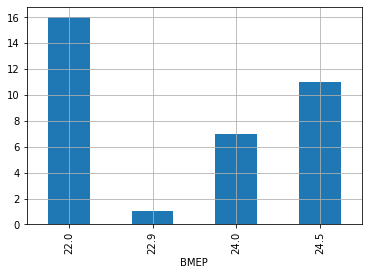

In [17]:
d.groupby( "BMEP")['Engine Type'].count().plot.bar(grid=True);

In [18]:
import plotly.express as px

#dd = d[['Name','oph parts','BMEP']].melt()
dd = d.sort_values(by = "oph parts",ascending=True)


In [19]:
px.bar(dd, x="BMEP", y="oph parts")

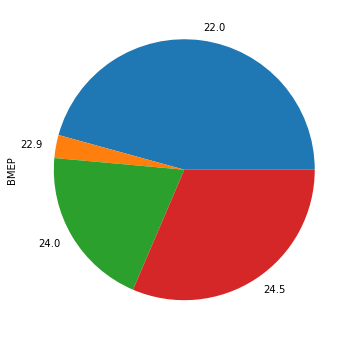

In [20]:
d.groupby( "BMEP")['Engine Type'].count().plot.pie(ylabel="BMEP",figsize=(6,6));

In [21]:
d.pivot(columns='Engine Type',values='BMEP').agg(['count','min','max']).round(1)

,612,616,620,624
count,1.0,9.0,6.0,19.0
min,22.0,22.0,22.0,22.9
max,22.0,22.0,22.0,24.5


## Statistics by Engine Version

In [22]:
d.groupby( "Engine Version")['oph parts'].describe().fillna(0).astype(int)

,count,mean,std,min,25%,50%,75%,max
Engine Version,,,,,,,,
F01,5,3746,244,3461,3589,3710,3895,4078
F03,1,2159,0,2159,2159,2159,2159,2159
F11,1,2845,0,2845,2845,2845,2845,2845
F12,1,3905,0,3905,3905,3905,3905,3905
H01,12,4913,1698,2485,4030,4817,5601,8565
H02,2,3900,4386,798,2349,3900,5451,7002
H12,1,1899,0,1899,1899,1899,1899,1899
J01,2,3887,417,3592,3739,3887,4034,4182
J101,2,6450,2674,4559,5504,6450,7396,8342


In [23]:
# tests arrow library 
import arrow
now = arrow.now().to('Europe/Vienna')
start=arrow.get('2020-02-07 14:00')
print(start.format('DD.MM.YYYY - HH:mm'))
print(now.format('DD.MM.YYYY - HH:mm'))

07.02.2020 - 14:00
31.03.2021 - 20:40


In [24]:
# Filter sites by names
name="M04 BMW LANDSHUT"
#ee = [e for e in vl.engines if name in e._d['Name']] 
ee = [e for e in vl.engines if name in e.__str__()] 
#ee = vl.eng_name(name)

for i, e in enumerate(ee):
    print(f"{i:02d} {e} {e.historical_dataItem(161, arrow.get(2020,12,28).timestamp)} oph")

## Engine Versions to Engine Type Table (Pivot Example)

In [25]:
d_subset=d.groupby('Engine Type').head(100)
d_subset.pivot(columns='Engine Type',values='Engine Version').fillna('-')

Engine Type,612,616,620,624
0,-,-,-,H01
1,-,F01,-,-
2,-,-,-,H02
3,-,F12,-,-
4,-,J01,-,-
5,-,J01,-,-
6,-,-,-,K01
7,-,-,-,K505
8,-,F11,-,-
9,-,-,F01,-


## Running hours vs Engine Version & Engine Type

In [26]:
d_subset.pivot_table(index='Engine Version', columns='Engine Type', values='oph parts', aggfunc=['count','sum'], margins=True).fillna('')

count                         sum                             \
Engine Type      612  616  620   624 All     612      616      620      624   
Engine Version                                                                
F01                   1.0  4.0         5           4078.0  14655.0            
F03                   1.0              1           2159.0                     
F11                   1.0              1           2845.0                     
F12                   1.0              1           3905.0                     
H01                             12.0  12                            58965.0   
H02                              2.0   2                             7800.0   
H12                              1.0   1                             1899.0   
J01                   2.0              2           7774.0                     
J101                  1.0  1.0         2           4559.0   8342.0            
J11                   1.0              1           2712.0                     
J12              1.0  1.0  1.0         3  2884.0   3785.0    789.0            
K01                              3.0   3                            12918.0   
K505                             1.0   1                             3825.0   
All              1.0  9.0  6.0  19.0  35  2884.0  31817.0  23786.0  85407.0   

                        
Engine Type        All  
Engine Version          
F01              18733  
F03               2159  
F11               2845  
F12               3905  
H01              58965  
H02               7800  
H12               1899  
J01               7774  
J101             12901  
J11               2712  
J12               7458  
K01              12918  
K505              3825  
All             143894

## Overall oph Statistics

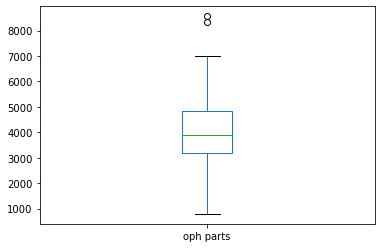

In [27]:
d[["oph parts"]].plot.box();

In [28]:
d['oph parts'].describe().astype(int)

count      35
mean     4111
std      1763
min       789
25%      3172
50%      3895
75%      4826
max      8565
Name: oph parts, dtype: int64

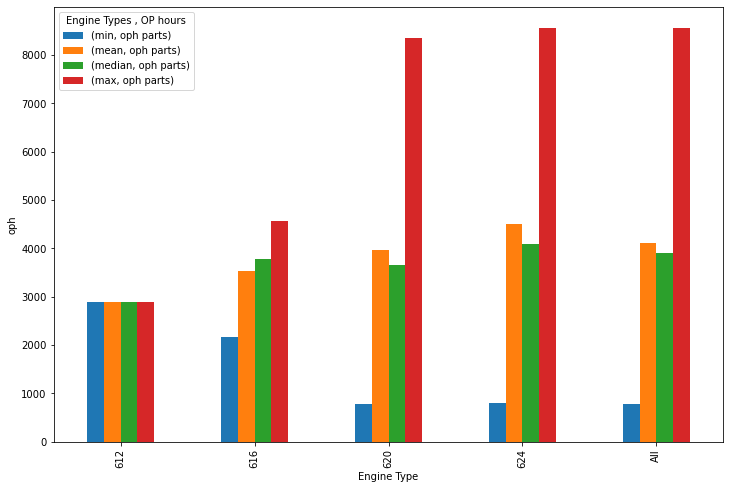

In [29]:
# lambda x: np.percentile(x, 50)
def median(x):
    return np.percentile(x,50)
d1 = d.pivot_table(index='Engine Type', values='oph parts', aggfunc=['min','mean',median,'max'], margins=True)
d1.columns=d1.columns.rename('Engine Types ', level=0)
d1.columns=d1.columns.rename(' OP hours', level=1)
d1.plot.bar(figsize=(12,8), ylabel='oph');

In [30]:
d.pivot_table(index='Engine Type', values='oph parts', aggfunc=['mean',median,'max','sum'], margins=True).round(1)

,mean,median,max,sum
,oph parts,oph parts,oph parts,oph parts
Engine Type,,,,
612,2884.0,2884.0,2884,2884
616,3535.2,3785.0,4559,31817
620,3964.3,3649.5,8342,23786
624,4495.1,4093.0,8565,85407
All,4111.3,3895.0,8565,143894


## Pivot Cum Validation hours per Engine Type

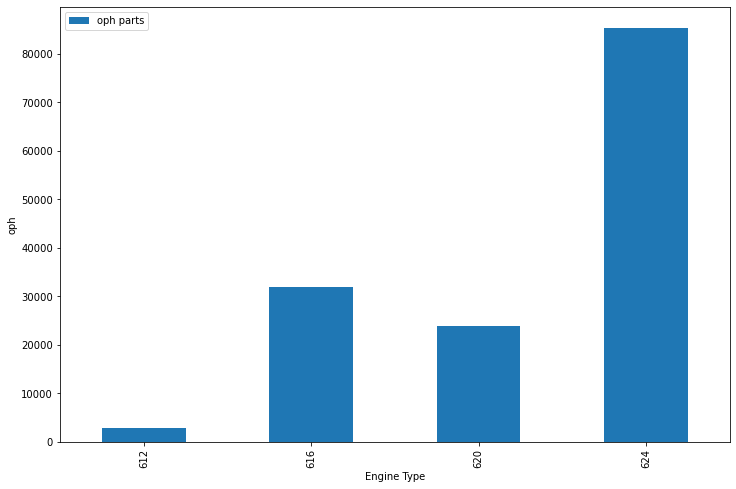

In [31]:
d.pivot_table(index='Engine Type', values='oph parts', aggfunc='sum', margins=False).plot.bar(figsize=(12,8), ylabel='oph');

In [32]:
# Select engine for detailed investigation
from pprint import pprint as pp
sn=1225799  #1320072
e=vl.eng_serialNumber(sn)
print(e)

1225799 M01 EC Mielec              


CPU times: user 80.1 ms, sys: 4.18 ms, total: 84.3 ms
Wall time: 1.14 s


(1000.0, 5000.0)

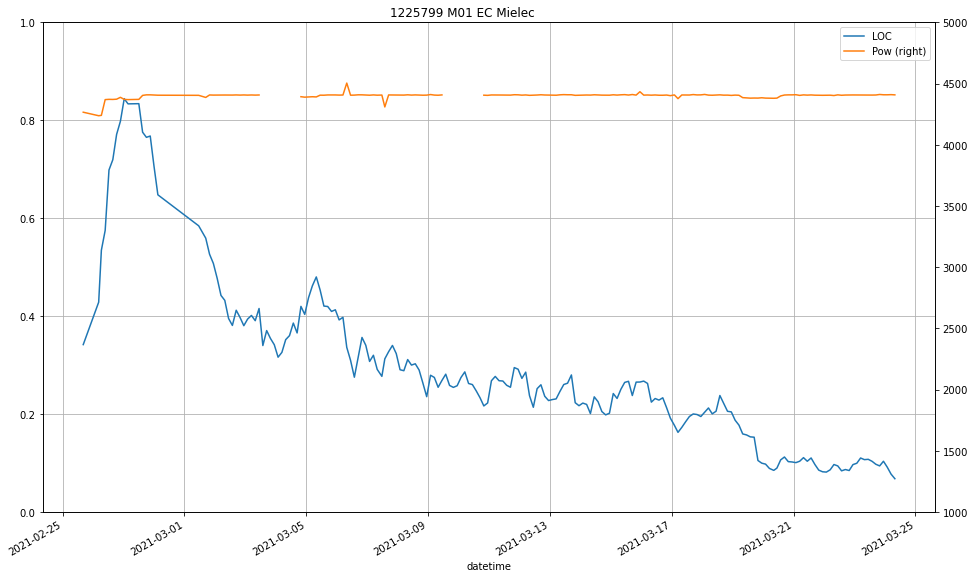

In [38]:
%%time
df= e.Validation_period_LOC()
dfl=df[['datetime','OilConsumption','LOC','AvgPower','Pow']]
dfl=df[['datetime','LOC','Pow']]
ax = dfl.plot(subplots=False, x='datetime', secondary_y=['AvgPower','Pow'], ylim=(0,1.0), figsize=(16,10), title=e, grid=True)
ax.set_ylim(1000,5000)

In [43]:
e=vl.eng_serialNumber(sn)
id = e.id

#parameters
#tto = arrow.now('Europe/Vienna')
#tto = arrow.get(2021,1,23,16,0)

#tfrom = arrow.get(e.valstart_ts)
#tfrom = arrow.get('2020-02-07')
#tfrom = tto.shift(months=-2) 

#tdef = {161: 'CountOph', 102: 'PowerAct'}
#ttimecycle='14400'
#tassetType='J-Engine'
#tincludeMinMax='false'
#tforceDownSampling='false'


In [46]:
df = e._batch_hist_dataItems(
    itemIds={
    161: ['CountOph'], 
    102: ['PowerAct'], 
    217: ['Hyd_PressCrankCase'],
    16546: ['Hyd_PressOilDif']
    }, 
    p_from=arrow.now('Europe/Vienna').shift(days=-7), 
    p_to=arrow.now('Europe/Vienna'),
    timeCycle=30)
# Set Type of time column to DateTime
df['datetime'] = pd.to_datetime(df['time'] * 1000000)
df['CountOph'] = df.CountOph - e.oph_start


# Just include the data to plot
dfp = df[['datetime','CountOph','PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif']]
#dfp.round(1)

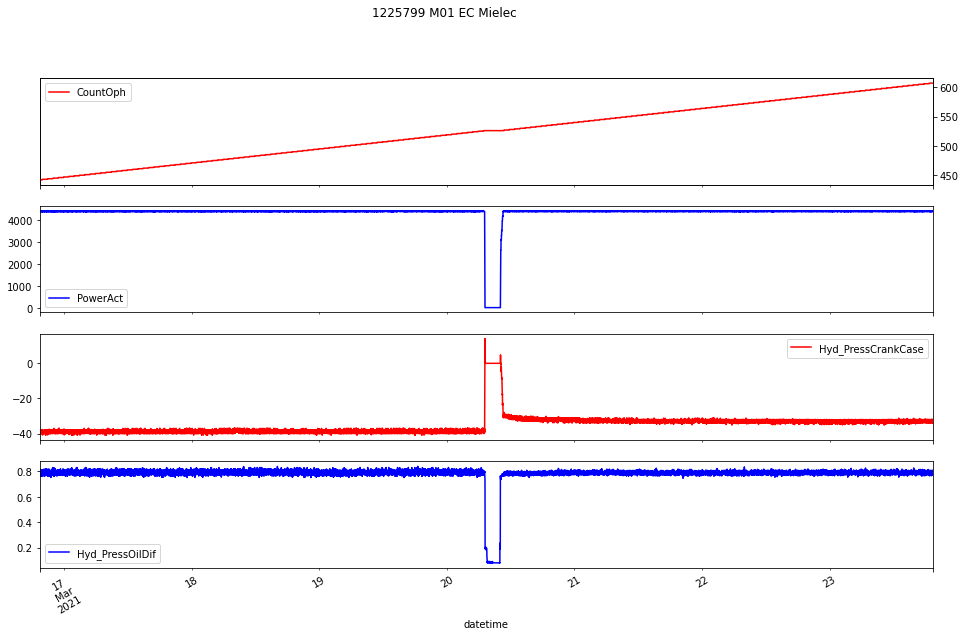

In [48]:
dfp.plot(subplots=True, x='datetime', color=['red','blue'], secondary_y = ['CountOph'], figsize=(16,10), title=e);


In [49]:
dfp.describe().round(1)

,CountOph,PowerAct,Hyd_PressCrankCase,Hyd_PressOilDif
count,20160.0,20160.0,20160.0,20160.0
mean,524.6,4326.7,-35.0,0.8
std,47.3,581.1,5.8,0.1
min,442.0,0.0,-41.0,0.1
25%,484.0,4402.7,-38.9,0.8
50%,526.0,4406.8,-34.8,0.8
75%,565.0,4410.8,-32.7,0.8
max,607.0,4429.4,14.1,0.8


In [50]:
# Alarms
"""
Get pandas dataFrame of Events history, either limit or From & to are required
batch_hist_alarms(self, p_severities=[600, 800], p_offset=0, p_limit=None, p_from=None, p_to=None)
p_severities          list   600,650 ... operational messages
                           700 ... warnings
                           800 ... alarms
p_offset            int64, number of messages to skip 
p_limit             int64, number of messages to download
p_from              string timestamp in milliseconds.
p_to                string timestamp in milliseconds.
"""
dm = e.batch_hist_alarms(p_severities=[800], p_offset=0, p_limit=10)
dm['datetime'] = pd.to_datetime(dm['timestamp'] * 1000000.0).dt.strftime("%d.%m.%Y %H:%m")
print(e, '\n')
print(tabulate(dm[['datetime','message','severity']], headers=['n','datetime','message','severity']))

1225799 M01 EC Mielec               

  n  datetime          message                                                            severity
---  ----------------  ---------------------------------------------------------------  ----------
  0  20.03.2021 08:03  Gas pre-alarm                                                           800
  1  20.03.2021 08:03  Fail safe loop tripped                                                  800
  2  20.03.2021 08:03  Emergency stop / safety loop                                            800
  3  20.03.2021 08:03  Gas alarm                                                               800
  4  05.03.2021 05:03  LEANOX controller allowed deviation exceeded                            800
  5  01.03.2021 10:03  Generator frequency too low                                             800
  6  25.02.2021 16:02  Turbocharger pre-lube pressure minimum                                  800
  7  25.02.2021 16:02  Measuring signal failure pressure after turbocha

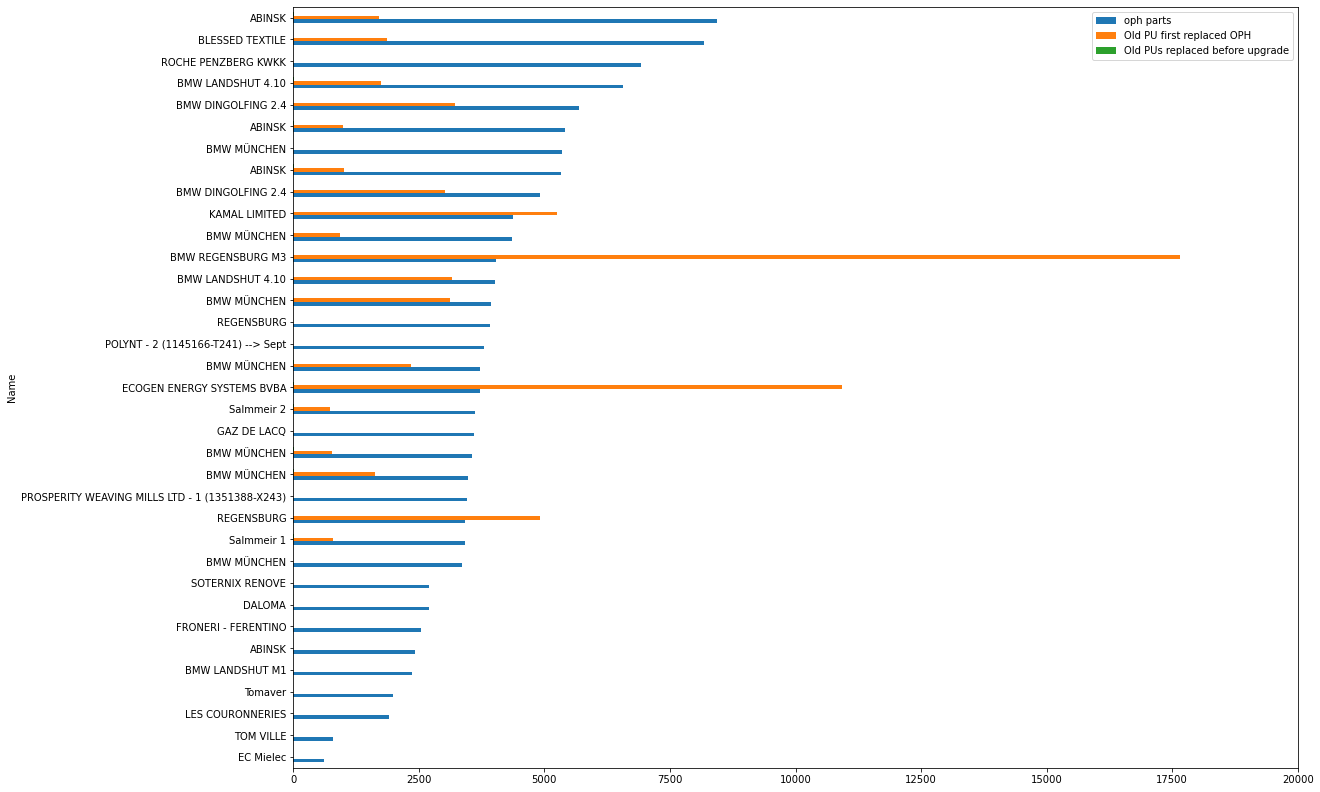

In [52]:
#dd = pd.DataFrame([])
#dd = d
#dd['Name'] = d['Name'] + ' ' + d['Engine Type'] + ' ' + d['Engine Version'] + ' ' + d['Engine ID']
#dc = pd.DataFrame([])
dc =  pd.concat([d[['Name','oph parts']], dval[['Old PU first replaced OPH','Old PUs replaced before upgrade']]],axis=1).set_index('Name').sort_values(by = "oph parts",ascending=True)
#print(dc)

dc.plot.barh(figsize=(18,14), xlim=(0,20000));
#dc.plot.scatter(x='Old PU first replaced OPH',y='Name',s='Old PUs replaced before upgrade')
# Please write SerialNumber of interesting Validation engine into sn: 
#sn=1393153

#for e in vl.engines:
#    print(e)
#    df = e.batch_hist_dataItems(itemIds={161: 'CountOph', 102: 'PowerAct'}, p_from=arrow.now('Europe/Vienna').shift(days=-7), p_to=arrow.now('Europe/Vienna'),timeCycle=3600)
#    # Set Type of time column to DateTime
#    df['datetime'] = pd.to_datetime(df['time'] * 1000000)
#    df['CountOph'] = df.CountOph - e._d['oph@start']
#
#    #dt = e.batch_hist_dataItems().plot(subplots=False, x='time', color=['red','black','blue'], secondary_y = ['CountOph'], figsize=(16,10))
#    df.plot(subplots=True, x='datetime', color=['red','black','blue'], y = ['CountOph','PowerAct'], title = e, figsize=(16,10))
#
#plt.show()

# print('----')
# for i, e in enumerate(vl.engines):
#    print(f"{i:02d} {e} {e.historical_dataItem(161, e.now_ts):6.0f} oph")


In [53]:
dat = {
    161: ['CountOph','h'], 
    102: ['PowerAct','kW'], 
    217: ['Hyd_PressCrankCase','mbar'],
    16546: ['Hyd_PressOilDif','bar']
    #,1001101: 'RMD_ListBuffMAvgOilConsume_OilConsumption'
}

df = e.hist_data(
    itemIds=dat, 
    #p_from=arrow.get(arrow.get(e.valstart_ts)), # 
    p_from=arrow.now('Europe/Vienna').shift(months=-1), 
    p_to=arrow.now('Europe/Vienna'),
    timeCycle=10*60)


# Set Type of time column to DateTime
df['datetime'] = pd.to_datetime(df['time'] * 1000000)
df['CountOph'] = df.CountOph - e.oph_start

25000it [00:03, 7606.56it/s]


In [54]:
df

,time,Hyd_PressOilDif,PowerAct,Hyd_PressCrankCase,CountOph,datetime
0,1614108342000,0.010000,0.000000,0.000000,0.000000,2021-02-23 19:25:42
1,1614108942000,0.010000,0.000000,0.000000,0.000000,2021-02-23 19:35:42
2,1614109542000,0.010000,0.000000,0.000000,0.000000,2021-02-23 19:45:42
3,1614110142000,0.009981,0.000000,0.000000,0.000000,2021-02-23 19:55:42
4,1614110742000,0.010000,0.000000,0.000000,0.000000,2021-02-23 20:05:42
...,...,...,...,...,...,...
4027,1616524542000,0.793325,4409.229663,-32.643412,606.122435,2021-03-23 18:35:42
4028,1616525142000,0.783552,4404.865528,-33.077382,607.000000,2021-03-23 18:45:42
4029,1616525742000,0.789832,4406.593083,-33.081827,607.000000,2021-03-23 18:55:42
4030,1616526342000,0.790037,4407.877093,-32.384572,607.000000,2021-03-23 19:05:42


In [55]:
# Filter outliers by < 3 * stdev
#df = df[np.abs(df.Hyd_PressCrankCase-df.Hyd_PressCrankCase.mean())
#        <= (2*df.Hyd_PressCrankCase.std())]
dff = df[df.Hyd_PressCrankCase <= 10.0]
#dff = dff[dff.PowerAct > 4000.0]

# Just include the data to plot
dfp = dff[['datetime','CountOph','PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif']]
#dfp['PowerAct'] = dfp.PowerAct.rolling(5).mean()
#dfp['Hyd_PressCrankCase'] = dfp.Hyd_PressCrankCase.rolling(20).mean()
#dfp.round(1)
dfp.set_index('datetime')

,CountOph,PowerAct,Hyd_PressCrankCase,Hyd_PressOilDif
datetime,,,,
2021-02-23 19:25:42,0.000000,0.000000,0.000000,0.010000
2021-02-23 19:35:42,0.000000,0.000000,0.000000,0.010000
2021-02-23 19:45:42,0.000000,0.000000,0.000000,0.010000
2021-02-23 19:55:42,0.000000,0.000000,0.000000,0.009981
2021-02-23 20:05:42,0.000000,0.000000,0.000000,0.010000
...,...,...,...,...
2021-03-23 18:35:42,606.122435,4409.229663,-32.643412,0.793325
2021-03-23 18:45:42,607.000000,4404.865528,-33.077382,0.783552
2021-03-23 18:55:42,607.000000,4406.593083,-33.081827,0.789832


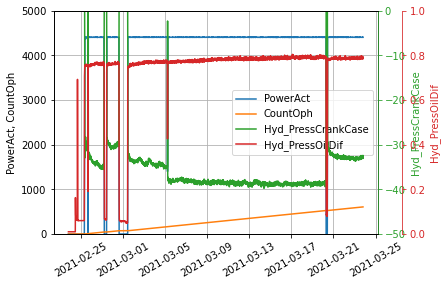

In [56]:
dmyplant2.chart(dfp, [
    {'col': ['PowerAct','CountOph'],'ylim': [0, 5000]},
    #{'col': ['CountOph'],'ylim': [0, 500]},
    {'col': ['Hyd_PressCrankCase'],'ylim': [-50, 0]},
    {'col': ['Hyd_PressOilDif'],'ylim': [0, 1]}
])

PowerAct
(-0.01, 176.24]        9.6
(176.24, 352.48]       0.0
(352.48, 528.72]       0.0
(528.72, 704.96]       0.0
(704.96, 881.2]        0.0
(881.2, 1057.44]       0.0
(1057.44, 1233.68]     0.0
(1233.68, 1409.92]     0.0
(1409.92, 1586.16]     0.0
(1586.16, 1762.4]      0.0
(1762.4, 1938.64]      0.0
(1938.64, 2114.88]     0.0
(2114.88, 2291.12]     0.0
(2291.12, 2467.36]     0.0
(2467.36, 2643.6]      0.0
(2643.6, 2819.84]      0.0
(2819.84, 2996.08]     0.0
(2996.08, 3172.32]     0.0
(3172.32, 3348.56]     0.0
(3348.56, 3524.8]      0.1
(3524.8, 3701.04]      0.1
(3701.04, 3877.28]     0.0
(3877.28, 4053.52]     0.1
(4053.52, 4229.76]     0.0
(4229.76, 4406.0]     21.6
Name: PowerAct, dtype: float64
Summe: 31.820436507936506%


<AxesSubplot:ylabel='PowerAct'>

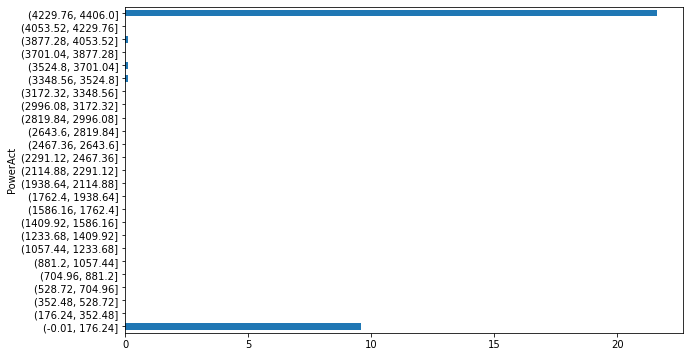

In [57]:

#dfp.PowerAct
#Calculate the number f engines in certain oph ranges
p = e.P_nominal
#ranges = [-0.1,2000,4000,6000]
ival=25
ranges = np.arange(0,ival+1,1)*p/ival
ranges[0] = ranges[0] - 0.01

#Method 1: using cut and groupby
r = dfp['PowerAct'].groupby(pd.cut(dfp['PowerAct'], ranges)).count()
rr = np.around(r / dfp['PowerAct'].count()*100,1)
print(rr)

print(f"Summe: {sum(r / dfp['PowerAct'].count()*100)}%")
rr.plot.barh(figsize=(10,6),ylim=(0,50))

#Method 2: simpler, direct using pd.value_counts
#dfp['PowerAct'].value_counts(bins=ranges, sort=False).astype(int).plot.bar(ylim=(0,20))
#dfp['PowerAct'].value_counts(bins=ranges, sort=False).astype(int)